In [ ]:
# from my experiments it seems like ExU units can't
# take 2D inputs so need to do the NAMs for multi-input
# but the residual based method seems to work for 2D at least!

In [1]:
# based on
# https://gitlab.com/SpaceTimeKhantinuum/scrinet/-/blob/master/examples/fits/nnfit-2d.ipynb

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

def relu_n(x, n = 1):
    """ReLU activation clipped at n."""
    return tf.clip_by_value(x, 0, n)


class ExU(Layer):
    def __init__(self, units):
        super(ExU, self).__init__()
        self.units = units
        self._w_initializer = tf.initializers.TruncatedNormal(
          mean=4.0, stddev=0.5)
        
    def build(self, input_shape):
        # input_shape[-1] is the number of features
        self.w = self.add_weight(
            name="w",
            shape=(input_shape[-1], self.units),
            initializer=self._w_initializer,
            trainable=True
        )
        self.b = self.add_weight(
            name="b",
            shape=(1, self.units),
            # NOTE HERE I INCREASED THE STDDEV! FROM 0.5 to 1.5. THIS REALLY HELPED FIT THE EDGES!
            initializer=tf.initializers.TruncatedNormal(stddev=1.5),
            trainable=True
        )
        
    def call(self, inputs):
        
#         this tile is row_stack tf.shape(x)[0] times
        centre = tf.tile(self.b, [tf.shape(inputs)[0], 1])
        return relu_n(tf.math.exp(self.w) * (inputs - centre))
#         return tf.matmul(inputs, self.w) + self.b

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
matplotlib.rcParams.update({'font.size': 16}) 

import numpy as np

In [3]:
import pugna.data

def preproc(data, method="MinMaxScaler", feature_range=(-1,1)):
    scalers = pugna.data.make_scalers(data, method=method, feature_range=feature_range)
    data_scaled = pugna.data.apply_scaler(data, scalers)
    return data_scaled, scalers

In [4]:
def gen_data(X):
    y = X[:,0] * np.sin(X[:,0]*10) + 1 + .4 * np.sin(X[:,1])
    y += np.random.uniform(0, 0.1, size=(len(y)))
    return y

In [5]:
# generate some fake data
x = np.linspace(0,1,5)
xx, yy = np.meshgrid(x,x)
xx = xx.ravel()
yy = yy.ravel()
X = np.zeros(shape=(len(xx), 2))
X[:,0] = xx
X[:,1] = yy

y = gen_data(X)

In [6]:
# validation data
# generate some fake data
x = np.linspace(0,1,20)
xx, yy = np.meshgrid(x,x)
xx = xx.ravel()
yy = yy.ravel()
X_val = np.zeros(shape=(len(xx), 2))
X_val[:,0] = xx
X_val[:,1] = yy

y_val = gen_data(X_val)

Text(0.5, 1.0, 'training set')

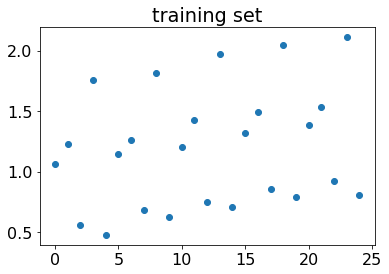

In [7]:
plt.figure()
plt.scatter(range(len(y)), y)
plt.title("training set")

Text(0.5, 1.0, 'validation set')

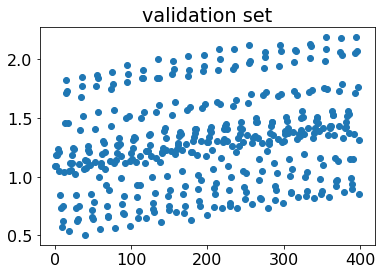

In [8]:
plt.figure()
plt.scatter(range(len(y_val)), y_val)
plt.title("validation set")

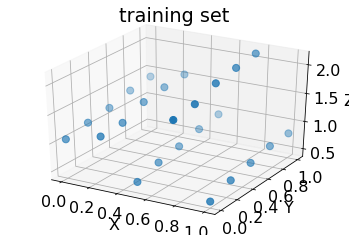

In [9]:
fig = plt.figure()
ax = fig.gca(projection="3d")
ax.scatter(X[:,0], X[:,1], y, s=50)
plt.xlabel("X")
plt.ylabel("Y")
ax.set_zlabel("Z")
plt.title("training set")
plt.show()

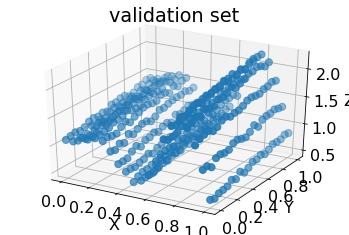

In [10]:
fig = plt.figure()
ax = fig.gca(projection="3d")
ax.scatter(X_val[:,0], X_val[:,1], y_val, s=50)
plt.xlabel("X")
plt.ylabel("Y")
ax.set_zlabel("Z")
plt.title("validation set")
plt.show()

In [11]:
X.shape

(25, 2)

In [12]:
y.shape

(25,)

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

In [14]:
def get_model():
    inputs = keras.Input(shape=(1,))
    x = ExU(200)(inputs)
#     x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dense(200, activation='relu')(x)
    x = layers.Dense(200, activation='relu')(x)
    x = layers.Dense(200, activation='relu')(x)
    x = layers.Dense(200, activation='relu')(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

In [15]:
def get_model_standard():
    inputs = keras.Input(shape=(2,))
#     x = ExU(100)(inputs)
    x = layers.Dense(1400, activation='relu')(inputs)
    x = layers.Dense(1400, activation='relu')(x)
#     x = layers.Dense(64, activation='relu')(x)
#     x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

In [16]:
model1 = get_model()
model2 = get_model()
model3 = get_model_standard()

In [17]:
inputs_0 = keras.Input(shape=(1,), name="0")
inputs_1 = keras.Input(shape=(1,), name="1")
inputs_01 = keras.Input(shape=(2,), name="01")
inputs = [inputs_0, inputs_1, inputs_01]

y1 = model1(inputs_0)
y2 = model2(inputs_1)
y3 = model3(inputs_01)

# addition_layer = layers.add([y1, y2, blayer])
addition_layer = layers.add([y1, y2, y3])
outputs = layers.Dense(1)(addition_layer)
ensemble_model = keras.Model(inputs=inputs, outputs=outputs)

In [18]:
ensemble_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
0 (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
1 (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
01 (InputLayer)                 [(None, 2)]          0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 1)            161401      0[0][0]                          
____________________________________________________________________________________________

In [19]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
ensemble_model.compile(loss='mse', optimizer=opt)

In [20]:
%%time
ensemble_history = ensemble_model.fit(
    {"0":X[:,0],"1":X[:,1], "01":X},
    y,
    epochs=1000, verbose=True,
    batch_size=X.shape[0]
)

Epoch 1/1000
1/1 [==============================] - 0s 981us/step - loss: 1.6214
Epoch 2/1000
1/1 [==============================] - 0s 880us/step - loss: 0.3413
Epoch 3/1000
1/1 [==============================] - 0s 925us/step - loss: 0.4841
Epoch 4/1000
1/1 [==============================] - 0s 832us/step - loss: 0.4499
Epoch 5/1000
1/1 [==============================] - 0s 2ms/step - loss: 0.2517
Epoch 6/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2269
Epoch 7/1000
1/1 [==============================] - 0s 865us/step - loss: 0.2700
Epoch 8/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.2537
Epoch 9/1000
1/1 [==============================] - 0s 832us/step - loss: 0.1986
Epoch 10/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1679
Epoch 11/1000
1/1 [==============================] - 0s 1ms/step - loss: 0.1825
Epoch 12/1000
1/1 [==============================] - 0s 783us/step - loss: 0.1893
Epoch 13/1000
1/1 [================

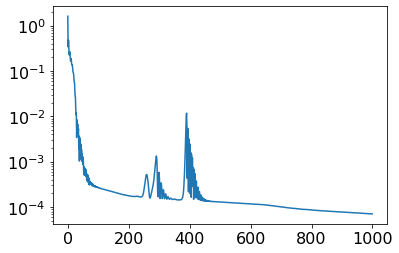

In [21]:
eh = ensemble_history.history['loss']
plt.figure()
plt.plot(range(len(eh)), eh)
plt.yscale('log')

In [22]:
ensemble_yhat = ensemble_model.predict({"0":X[:,0],"1":X[:,1],"01":X})

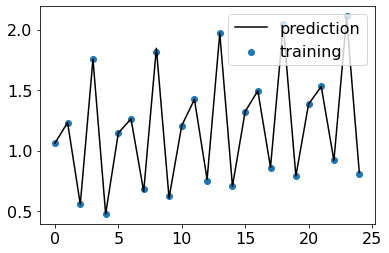

In [23]:
plt.figure()
plt.scatter(range(len(y)), y, label='training')
plt.plot(range(len(y)), ensemble_yhat, label='prediction', c='k')
plt.legend()

In [24]:
ensemble_yhat_val = ensemble_model.predict({"0":X_val[:,0],"1":X_val[:,1], "01":X_val})

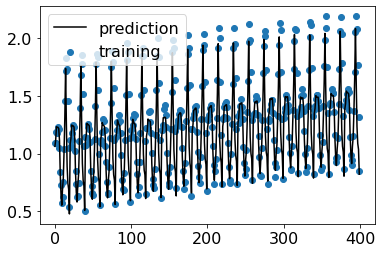

In [25]:
plt.figure()
plt.scatter(range(len(y_val)), y_val, label='training')
plt.plot(range(len(y_val)), ensemble_yhat_val, label='prediction', c='k')
plt.legend()

Text(0.5, 1.0, 'training set difference')

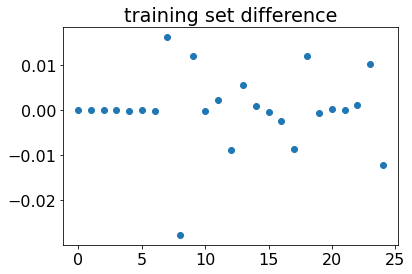

In [26]:
plt.figure()
plt.scatter(range(len(y)), y - ensemble_yhat.reshape(-1))
plt.title("training set difference")

Text(0.5, 1.0, 'training set difference')

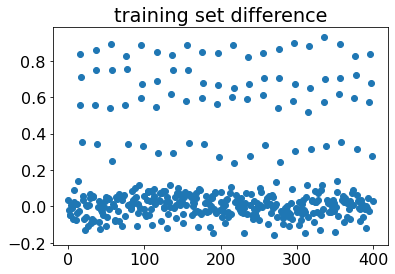

In [27]:
plt.figure()
plt.scatter(range(len(y_val)), y_val - ensemble_yhat_val.reshape(-1))
plt.title("training set difference")

In [28]:
n_arr = np.arange(y.shape[0])
n_val_arr = np.arange(y_val.shape[0])

In [29]:
y.shape

(25,)

In [30]:
ensemble_yhat.shape

(25, 1)

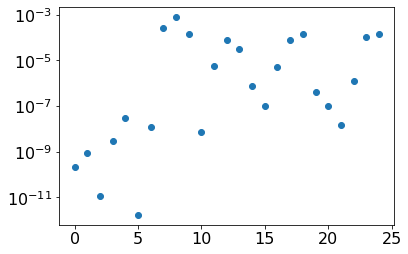

In [31]:
plt.figure()
plt.scatter(n_arr, tf.keras.losses.mean_squared_error(y[:,np.newaxis], ensemble_yhat))
plt.yscale('log')

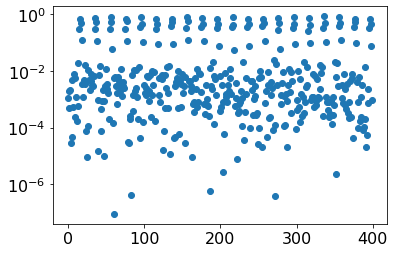

In [32]:
plt.figure()
plt.scatter(n_val_arr, tf.keras.losses.mean_squared_error(y_val[:,np.newaxis], ensemble_yhat_val))
plt.yscale('log')